In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import pdb
from collections import Counter
%matplotlib inline

In [3]:
import sys
#sys.path.append('../')
from utils import partitions

In [4]:
def str_to_tup(x):
    return tuple(int(i) for i in x)

In [5]:
def px_mult(p1, p2):
    return tuple(
        p1[p2[i] - 1] for i in range(len(p1))
    )

In [6]:
MOVES = [
    (4, 2, 3, 5, 8, 6, 7, 1), 
    (8, 2, 3, 1, 4, 6, 7, 5), 
    (2, 7, 3, 4, 5, 6, 8, 1), 
    (8, 1, 3, 4, 5, 6, 2, 7), 
    (2, 3, 4, 1, 5, 6, 7, 8), 
    (4, 1, 2, 3, 5, 6, 7, 8),
    (8, 2, 3, 1, 4, 6, 7, 5), 
    (4, 2, 3, 5, 8, 6, 7, 1), 
    (8, 1, 3, 4, 5, 6, 2, 7), 
    (2, 7, 3, 4, 5, 6, 8, 1), 
    (4, 1, 2, 3, 5, 6, 7, 8), 
    (2, 3, 4, 1, 5, 6, 7, 8),
]
def nbrs(ptup):
    ns = [px_mult(m, ptup) for m in MOVES]
    return ns

In [7]:
def df_to_idx_dict(df):
    idx_dict = {}
    for idx, row in df.iterrows():
        ptup = str_to_tup(row[0])
        idx_dict[ptup] = idx
    return idx_dict

def df_to_dist_dict(df):
    dist_dict = {}
    for idx, row in df.iterrows():
        ptup = str_to_tup(row[0])
        dist_dict[ptup] = row[1]
    return dist_dict

In [8]:
def gen_adj(df, idx_dict):
    adj = np.zeros((len(df), len(df)))
    for idx, row in df.iterrows():
        ptup = str_to_tup(row[0])
        ns = nbrs(ptup)
        nbr_idx = [idx_dict[n] for n in ns]
        adj[idx, nbr_idx] = 1
    return adj

def gen_laplacian(adj):
    deg = np.diag(adj.sum(axis=1))
    return deg - adj

def gen_normalized_laplacian(adj):
    lapl = gen_laplacian(adj)
    inv_deg = 1.0 / adj.sum(axis=1)
    inv_rt_deg = np.sqrt(np.diag(inv_deg))
    return inv_rt_deg @ lapl @ inv_rt_deg

def gen_nlap(adj):
    inv_deg = 1.0 / adj.sum(axis=1)
    inv_rt_deg = np.sqrt(np.diag(inv_deg))
    return np.eye(adj.shape[0]) - (inv_rt_deg @ adj @ inv_rt_deg)

In [11]:
df = pd.read_csv('/home/hopan/github/idastar/s8_dists_fixedcore.txt', header=None,
                 dtype={0: str, 1:int})
true_dist = df[1].values
dist_dict = df_to_dist_dict(df)
idx_dict = df_to_idx_dict(df)
states = list(dist_dict.keys())
adj = gen_adj(df, idx_dict)
lapl = gen_laplacian(adj)
nlapl = gen_normalized_laplacian(adj)

In [12]:
discounted_distance = np.array([0.8 ** x for x in true_dist])

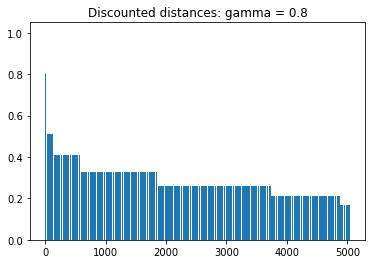

In [13]:
plt.bar(range(5040), discounted_distance)
plt.title('Discounted distances: gamma = 0.8')
plt.show()

In [14]:
# torch versions
adj_th = torch.from_numpy(adj)
lapl_th = torch.from_numpy(lapl)
nlapl_th = torch.from_numpy(nlapl)

In [15]:
# eigs of laplacian and normalized laplacian
lval, lvec = torch.symeig(lapl_th, eigenvectors=True)
nlval, nlvec = torch.symeig(nlapl_th, eigenvectors=True)

In [16]:
# numpy versions
lvalnp = lval.numpy()
lvecnp = lvec.numpy()
nlvalnp = nlval.numpy()
nlvecnp = nlvec.numpy()

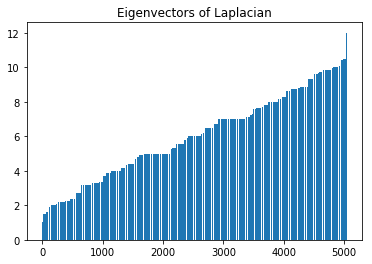

In [20]:
plt.bar(range(len(lval)), lvalnp)
plt.title('Eigenvals of Laplacian')
plt.show()

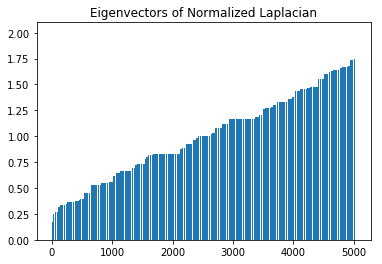

In [21]:
plt.bar(range(len(nlval)), nlvalnp)
plt.title('Eigenvals of Normalized Laplacian')
plt.show()

## Eigenvectors of the Graph Laplacian
Recall that the graph laplacian is $L = D - A$ and has the following block diagonal form after a change of basis:
$$T L T^{\dagger} = T (I - A) T ^ \dagger = I - T A T^\dagger$$
The adjacency matrix is the sum of the regular representations of the generators which block diagoalizes into the irreps. Let $\Gamma$ be the set of generators of our group. Then:
$$\rho_{reg} (\sigma) = \oplus_{\rho} \oplus_{l = 0}^{d_\rho} \rho (\sigma)$$
So
$$ T A T^{-1} =  \oplus_{\rho} \oplus_{l = 0}^{d_\rho} \sum_{\sigma \in \Gamma} \rho (\sigma)$$
This tells us that the eigenvalues of each $M_{\rho} = \sum_{\sigma \in \Gamma} \rho(\sigma)$ matrix will give us the eigenvectors of the graph laplacian and that the eigenvalues of $M_\rho$ appear with multiplicity $d_\rho$.

However, as we can see from our experiments, this is not the case.

In [22]:
def prob_correct(state, idx_dict, dist_dict, vec):
    ns = nbrs(state)
    opt_nbr = None
    opt_nbr_dist = None
    for n in ns:
        idx = idx_dict[n]
        
        ndist = dist_dict[idx]
        vdist = vec[idx]
        
        if ndist < opt_nbr_dist:
            opt_nbr_dist = ndist
            opt_nbr = n
    return 

In [23]:
def get_alphas(true_dist, vecs):
    # columns of vecs are the basis
    # compute the projection of true dist onto v for each v in vecs
    vect = vecs.T
    return vect.dot(true_dist)

In [26]:
def reconstruct_top_k(srt_vecs, srt_alphas, k):
    # each col of srt vecs is an eigvec
    return srt_vecs[:, :k].dot(srt_alphas[:k])

In [24]:
alphas_lap = get_alphas(lvecnp, true_dist)
alphas_discount = get_alphas(lvecnp, discounted_distance)

# take magnitude of alphas bc we care about which alphas contribute the "most"
abs_alphas_lap = np.abs(alphas_lap)
abs_alphas_disc = np.abs(alphas_discount)

# compute sorted order of eigvals by abs value of coefficients
abs_lap_order = np.argsort(-abs_alphas_lap) # sort by largest of the absolute values of alphas for true distance
abs_disc_order = np.argsort(-abs_alphas_disc)

# sort alphas
srt_alphas_lap = alphas_lap[abs_lap_order]
srt_alphas_disc = alphas_discount[abs_disc_order]

# sort the eigevecs
srt_lvecnp = lvecnp[:, abs_lap_order]
srt_lvecnp_disc = lvecnp[:, abs_disc_order]

/home/hopan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hopan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


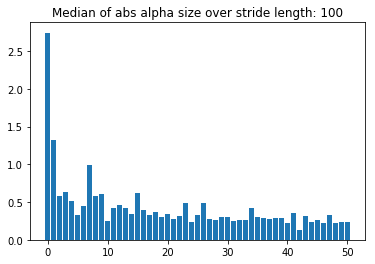

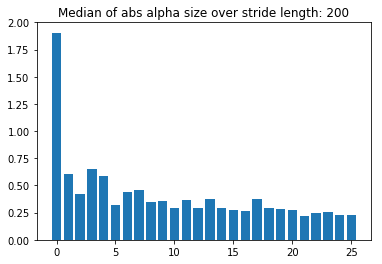

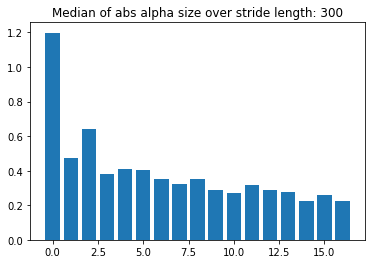

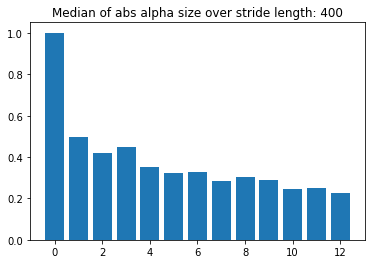

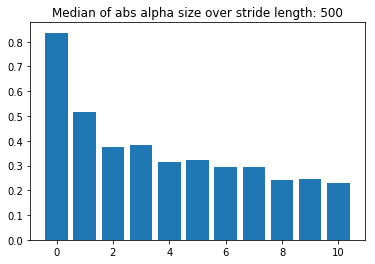

In [34]:
strides = [100, 200, 300, 400, 500]
for stride in strides:
    k = 0
    stuff = []
    for k in range(len(alphas_lap // stride)):
        stuff.append(np.median(np.abs(alphas_lap[k * stride: k * stride+ stride])))
    plt.bar(range(len(stuff)), stuff)
    plt.title('Median of abs alpha size over stride length: {}'.format(stride))
    plt.show()

/home/hopan/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hopan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


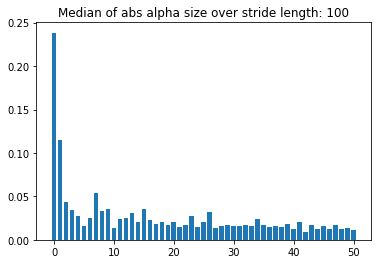

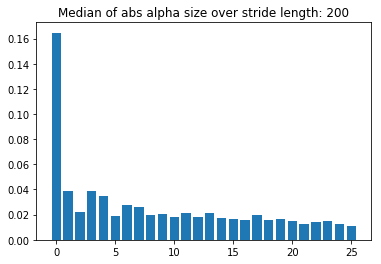

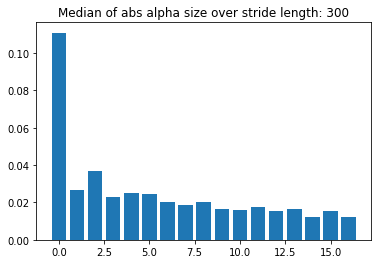

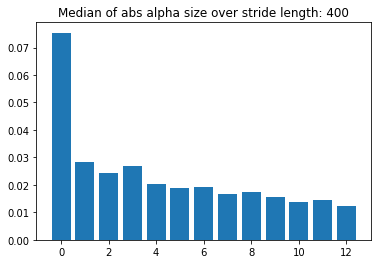

In [35]:
strides = [100, 200, 300, 400]
for stride in strides:
    k = 0
    stuff = []
    for k in range(len(alphas_discount // stride)):
        stuff.append(np.median(np.abs(alphas_discountcount[k * stride: k * stride+ stride])))
    plt.bar(range(len(stuff)), stuff)
    plt.title('Median of abs alpha size over stride length: {}'.format(stride))
    plt.show()

In [34]:
print('Reconstructed discounted {:.4f} | expected: {:.4f}'.format(
    reconstruct_top_k(srt_lvecnp, srt_alphas_lap, 5040)[-1],
    8
))

Reconstructed discounted 8.0000 | expected: 8.0000


In [33]:
print('Reconstructed discounted {:.4f} | expected: {:.4f}'.format(
    reconstruct_top_k(srt_lvecnp_disc, srt_alphas_disc, 5040)[-1],
    0.16777216
))

Reconstructed discounted 0.1678 | expected: 0.1678


In [ ]:
%time plt.bar(range(5039), np.abs(srt_alphas_lap[1:]))
%time plt.show()

In [ ]:
%time plt.bar(range(5039), np.abs(srt_alphas_disc[1:]))
%time plt.show()

In [38]:
%time plt.bar(range(5039), srt_alphas_disc[1:])
%time plt.show()

0.0012201371484716742

In [95]:
np.save('/local/hopan/s8cube/lap_eigvecs', lvecnp)

In [60]:
def get_prop_correct(states, idx_dict, true_dist, fvec, reverse=False):
    '''
    Using fvec as the policy, see what proportion of the given states get pushed to a closer state (as given
    by the true_dist vector)
    states: list of tuples
    idx_dict: dictionary mapping tuple (representing states) to ints (index into true_dist and fvec)
    true_dist:
    fvec: 
    '''
    scale = -1 if reverse else 1
    n_correct = 0
    for p in states:
        ns = nbrs(p)
        nbr_idx = [idx_dict[n] for n in ns]
        nbr_dist = scale * true_dist[nbr_idx]
        nbr_dapprox = scale * fvec[nbr_idx]
        
        min_nbr_dist = np.min(nbr_dist)
        min_idxs = [idx for idx, v in enumerate(nbr_dist) if v == min_nbr_dist]
        if np.argmin(nbr_dapprox) in min_idxs:
            n_correct += 1
    return n_correct / len(states)

In [61]:
tot = np.linalg.norm(np.abs(srt_alphas_lap[1:]))
ks = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5039]
for k in (ks):
    norm = np.linalg.norm(np.abs(srt_alphas_lap[1:k+1])) / tot
    krecon = reconstruct_top_k(srt_lvecnp, srt_alphas_lap, k)
    acc = get_prop_correct(states, idx_dict, true_dist, krecon)
    print('Top {:4d} | Prop norm: {:.3f} | Prop eigs: {:.3f} | Prop correct move: {:.3f}'.format(k, norm, k / 5039, acc))

Top   10 | Prop norm: 0.647 | Prop eigs: 0.002 | Prop correct move: 0.827
Top   20 | Prop norm: 0.714 | Prop eigs: 0.004 | Prop correct move: 0.874
Top   40 | Prop norm: 0.768 | Prop eigs: 0.008 | Prop correct move: 0.921
Top   80 | Prop norm: 0.819 | Prop eigs: 0.016 | Prop correct move: 0.962
Top  160 | Prop norm: 0.863 | Prop eigs: 0.032 | Prop correct move: 0.988
Top  320 | Prop norm: 0.902 | Prop eigs: 0.064 | Prop correct move: 0.998
Top  640 | Prop norm: 0.938 | Prop eigs: 0.127 | Prop correct move: 1.000
Top 1280 | Prop norm: 0.969 | Prop eigs: 0.254 | Prop correct move: 1.000
Top 2560 | Prop norm: 0.993 | Prop eigs: 0.508 | Prop correct move: 1.000
Top 5039 | Prop norm: 1.000 | Prop eigs: 1.000 | Prop correct move: 1.000


In [65]:
# Using top k eigenvectors by their eigenvalue
tot = np.linalg.norm(np.abs(alphas_lap[1:]))
ks = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5039]
for k in (ks):
    norm = np.linalg.norm(np.abs(alphas_lap[1:k+1])) / tot
    krecon = reconstruct_top_k(lvecnp, alphas_lap, k)
    acc = get_prop_correct(states, idx_dict, true_dist, krecon)
    print('Top {:4d} | Prop norm: {:.3f} | Prop eigs: {:.3f} | Prop correct move: {:.3f}'.format(k, norm, k / 5039, acc))

Top   10 | Prop norm: 0.481 | Prop eigs: 0.002 | Prop correct move: 0.707
Top   20 | Prop norm: 0.606 | Prop eigs: 0.004 | Prop correct move: 0.783
Top   40 | Prop norm: 0.673 | Prop eigs: 0.008 | Prop correct move: 0.853
Top   80 | Prop norm: 0.762 | Prop eigs: 0.016 | Prop correct move: 0.909
Top  160 | Prop norm: 0.805 | Prop eigs: 0.032 | Prop correct move: 0.958
Top  320 | Prop norm: 0.830 | Prop eigs: 0.064 | Prop correct move: 0.986
Top  640 | Prop norm: 0.866 | Prop eigs: 0.127 | Prop correct move: 0.984
Top 1280 | Prop norm: 0.917 | Prop eigs: 0.254 | Prop correct move: 0.999
Top 2560 | Prop norm: 0.955 | Prop eigs: 0.508 | Prop correct move: 1.000
Top 5039 | Prop norm: 1.000 | Prop eigs: 1.000 | Prop correct move: 1.000


In [66]:
# using the top k alpha eigenvectors for alpha = discounted distance vector
tot = np.linalg.norm(np.abs(srt_alphas_disc[1:]))
ks = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5039]
for k in (ks):
    norm = np.linalg.norm(np.abs(srt_alphas_disc[1:k+1])) / tot
    krecon = reconstruct_top_k(srt_lvecnp_disc, srt_alphas_disc, k)
    acc = get_prop_correct(states, idx_dict, discounted_distance, krecon, reverse=True)
    print('Top {:4d} | Prop norm: {:.3f} | Prop eigs: {:.3f} | Prop correct move: {:.3f}'.format(k, norm, k / 5039, acc))

Top   10 | Prop norm: 0.654 | Prop eigs: 0.002 | Prop correct move: 0.826
Top   20 | Prop norm: 0.724 | Prop eigs: 0.004 | Prop correct move: 0.875
Top   40 | Prop norm: 0.789 | Prop eigs: 0.008 | Prop correct move: 0.922
Top   80 | Prop norm: 0.848 | Prop eigs: 0.016 | Prop correct move: 0.962
Top  160 | Prop norm: 0.895 | Prop eigs: 0.032 | Prop correct move: 0.989
Top  320 | Prop norm: 0.929 | Prop eigs: 0.064 | Prop correct move: 0.999
Top  640 | Prop norm: 0.957 | Prop eigs: 0.127 | Prop correct move: 1.000
Top 1280 | Prop norm: 0.979 | Prop eigs: 0.254 | Prop correct move: 1.000
Top 2560 | Prop norm: 0.995 | Prop eigs: 0.508 | Prop correct move: 1.000
Top 5039 | Prop norm: 1.000 | Prop eigs: 1.000 | Prop correct move: 1.000


In [67]:
# using the top k alpha eigenvectors for alpha = discounted distance vector
tot = np.linalg.norm(np.abs(alphas_discount[1:]))
ks = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5039]
for k in (ks):
    norm = np.linalg.norm(np.abs(alphas_discount[1:k+1])) / tot
    krecon = reconstruct_top_k(lvecnp, alphas_discount, k)
    acc = get_prop_correct(states, idx_dict, discounted_distance, krecon, reverse=True)
    print('Top {:4d} | Prop norm: {:.3f} | Prop eigs: {:.3f} | Prop correct move: {:.3f}'.format(k, norm, k / 5039, acc))

Top   10 | Prop norm: 0.479 | Prop eigs: 0.002 | Prop correct move: 0.707
Top   20 | Prop norm: 0.607 | Prop eigs: 0.004 | Prop correct move: 0.781
Top   40 | Prop norm: 0.681 | Prop eigs: 0.008 | Prop correct move: 0.854
Top   80 | Prop norm: 0.789 | Prop eigs: 0.016 | Prop correct move: 0.912
Top  160 | Prop norm: 0.851 | Prop eigs: 0.032 | Prop correct move: 0.965
Top  320 | Prop norm: 0.887 | Prop eigs: 0.064 | Prop correct move: 0.990
Top  640 | Prop norm: 0.907 | Prop eigs: 0.127 | Prop correct move: 0.993
Top 1280 | Prop norm: 0.943 | Prop eigs: 0.254 | Prop correct move: 1.000
Top 2560 | Prop norm: 0.971 | Prop eigs: 0.508 | Prop correct move: 1.000
Top 5039 | Prop norm: 1.000 | Prop eigs: 1.000 | Prop correct move: 1.000


In [68]:
def get_random_baseline(states, idx_dict, true_dist, reverse=False):
    scale = -1 if reverse else 1
    n_correct = 0
    for p in states:
        ns = nbrs(p)
        nbr_idx = [idx_dict[n] for n in ns]
        nbr_dist = scale * true_dist[nbr_idx]
        
        min_nbr_dist = np.min(nbr_dist)
        min_idxs = [idx for idx, v in enumerate(nbr_dist) if v == min_nbr_dist]
        #pdb.set_trace()
        if np.random.randint(len(ns) + 1) in min_idxs:
            n_correct += 1
    return n_correct / len(states)

In [85]:
shuffled_states = states[:]
random.shuffle(shuffled_states)

In [91]:
get_random_baseline(shuffled_states, idx_dict, true_dist)

0.4589285714285714

In [68]:
get_random_baseline(states, idx_dict, discounted_distance, reverse=True)

0.4601190476190476

In [103]:
lval[-10:]

tensor([10.9817, 10.9817, 10.9817, 10.9817, 10.9817, 10.9817, 10.9817, 10.9817,
        10.9817, 12.0000], dtype=torch.float64)

In [73]:
tot = np.linalg.norm(np.abs(srt_alphas_lap[1:]))
ks = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5039]
for k in (ks):
    norm = np.linalg.norm(np.abs(alphas_lap[1:k+1])) / tot
    #krecon = reconstruct_top_k(srt_lvecnp, srt_alphas_lap, k)
    krecon = reconstruct_top_k(lvecnp, alphas_lap, k)
    acc = get_prop_correct(states, idx_dict, true_dist, krecon)
    print('Top {:4d} | Prop norm: {:.3f} | Prop eigs: {:.3f} | Prop correct move: {:.3f}'.format(k, norm, k / 5039, acc))

Top   10 | Prop norm: 0.481 | Prop eigs: 0.002 | Prop correct move: 0.707
Top   20 | Prop norm: 0.606 | Prop eigs: 0.004 | Prop correct move: 0.783
Top   40 | Prop norm: 0.673 | Prop eigs: 0.008 | Prop correct move: 0.853
Top   80 | Prop norm: 0.762 | Prop eigs: 0.016 | Prop correct move: 0.909
Top  160 | Prop norm: 0.805 | Prop eigs: 0.032 | Prop correct move: 0.958
Top  320 | Prop norm: 0.830 | Prop eigs: 0.064 | Prop correct move: 0.986
Top  640 | Prop norm: 0.866 | Prop eigs: 0.127 | Prop correct move: 0.984
Top 1280 | Prop norm: 0.917 | Prop eigs: 0.254 | Prop correct move: 0.999
Top 2560 | Prop norm: 0.955 | Prop eigs: 0.508 | Prop correct move: 1.000
Top 5039 | Prop norm: 1.000 | Prop eigs: 1.000 | Prop correct move: 1.000


In [77]:
tot = np.linalg.norm(np.abs(srt_alphas_disc[1:]))
ks = [10, 20, 40, 80, 160, 320, 640, 1280, 2560, 5039]
for k in (ks):
    norm = np.linalg.norm(np.abs(alphas_discount[1:k+1])) / tot
    #krecon = reconstruct_top_k(srt_lvecnp, srt_alphas_lap, k)
    krecon = reconstruct_top_k(lvecnp, alphas_discount, k)
    acc = get_prop_correct(states, idx_dict, discounted_distance, krecon, reverse=True)
    print('Top {:4d} | Prop norm: {:.3f} | Prop eigs: {:.3f} | Prop correct move: {:.3f}'.format(k, norm, k / 5039, acc))

Top   10 | Prop norm: 0.479 | Prop eigs: 0.002 | Prop correct move: 0.707
Top   20 | Prop norm: 0.607 | Prop eigs: 0.004 | Prop correct move: 0.781
Top   40 | Prop norm: 0.681 | Prop eigs: 0.008 | Prop correct move: 0.854
Top   80 | Prop norm: 0.789 | Prop eigs: 0.016 | Prop correct move: 0.912
Top  160 | Prop norm: 0.851 | Prop eigs: 0.032 | Prop correct move: 0.965
Top  320 | Prop norm: 0.887 | Prop eigs: 0.064 | Prop correct move: 0.990
Top  640 | Prop norm: 0.907 | Prop eigs: 0.127 | Prop correct move: 0.993
Top 1280 | Prop norm: 0.943 | Prop eigs: 0.254 | Prop correct move: 1.000
Top 2560 | Prop norm: 0.971 | Prop eigs: 0.508 | Prop correct move: 1.000
Top 5039 | Prop norm: 1.000 | Prop eigs: 1.000 | Prop correct move: 1.000


In [282]:
srt_lvalnp = lvalnp[abs_lap_order]
srt_lvecnp = lvecnp[:, abs_lap_order]

In [ ]:
def heat_kernel(eigval, beta):
    return torch.exp(eigval * beta)

def hk_mat(eigval, eigvec, beta):
    '''
    Computes e^{\beta L}. Note this is NOT just elementwise exponentiation
    e^{\beta L} = \sum_{n = 0}^\infty \beta^n L^n / n!
    '''
    evs = heat_kernel(eigval, beta)
    return eigvec.matmul(torch.diag(evs).matmul(eigvec.t()))

In [ ]:
mat = lap_eigvec.matmul(torch.diag(lap_eig).matmul(lap_eigvec.t()))

In [ ]:
input_state =torch.zeros(len(lap_eig), 1).type_as(mat)
input_state[0, 0] = 1

In [ ]:
betas = [0.1, 0.2, 0.4, 0.8]
idx = np.arange(len(lap_eig))
for b in betas:
    diff_mat = hk_mat(lap_eig, lap_eigvec, b)
    res = diff_mat.matmul(input_state).squeeze(-1)
    res = res.numpy()
    plt.bar(idx, res)
    plt.show()

In [ ]:
m1 = hk_mat(lap_eig, lap_eigvec, beta=1)
p1 = np.matmul(m1, input_state).reshape(-1)

In [ ]:
st = 2000
k = 3000
plt.bar(range(k), p1[st:st+k])

In [ ]:
#m4 = hk_mat(lap_eig, lap_eigvec, beta=0.4)
m12 = hk_mat(lap_eig, lap_eigvec, beta=0.412)

In [ ]:
p4 = np.matmul(m4, input_state).reshape(-1)
p12 = np.matmul(m12, input_state).reshape(-1)

In [ ]:
plt.bar(range(len(lap_eig)), p4)
plt.ylim(0, p4[1])
plt.show()

In [ ]:
plt.bar(range(len(lap_eig)), p12)
plt.ylim(0, p12[1])
plt.show()

In [ ]:
plt.bar(idx[:1000], res[:1000])
plt.ylim(0, 0.04)
plt.show()

In [ ]:
plt.bar(range(len(lap_eig)), -lap_eig)
plt.show()

In [ ]:
def gen_feval_func(idx_dict, vec):
    def f(ptup):
        idx = idx_dict[ptup]
        return -vec[idx]
    return f

In [ ]:
def is_done(ptup):
    return ptup == (1,2,3,4,5,6,7,8)

def neighbors(ptup):
    ns = [px_mult(m, ptup) for m in MOVES]
    return ns

In [ ]:
import pdb

In [ ]:
tups = list(idx_dict.keys())

In [ ]:
def rand_el(tups):
    return random.choice(tups)

In [ ]:
id_tup = (1,2,3,4,5,6,7,8)
g = rand_el(tups)
gdist = dist_dict[g]
maxiters = 20
feval4 = gen_feval_func(idx_dict, p4)
feval12 = gen_feval_func(idx_dict, p12)
feval1 = gen_feval_func(idx_dict, p1)
print(gdist, g)

todo: approximate true function with the fourier basis
sort them by alpha, see how prop correct by num basis functions?
- eigvalues are already sorted

In [ ]:
def alphas_true_dist(true_dist, vecs):
    alphas = vecs.T.dot(true_dist)
    return alphas

In [ ]:
true_dist = df[1]
lap_ev_np = lap_eigvec.numpy()
%time alphas = alphas_true_dist(true_dist, lap_ev_np)

In [208]:
res_alphas = lap_ev_np.dot(alphas)

NameError: name 'lap_ev_np' is not defined

In [ ]:
sorted_abs = np.sort(np.abs(alphas))

In [ ]:
plt.bar(range(len(alphas)), sorted_abs)
plt.show()

We've computed the alphas for the eigenvectors
now we'd like to see, using the largest alpha eigenvectors, how often do we move from cube state to an "optimal" neighbor?

In [ ]:
x = np.array([1, 3, 2, 4])
np.argsort(x)

In [ ]:
sorted_idx_alphas = np.argsort(alphas)

In [ ]:
plt.hist(lap_ev_np[-2], bins=30)
plt.show()

In [ ]:
lap_ev_np[sorted_idx_alphas].shape

In [ ]:
idxset = set(sorted_idx_alphas)

In [ ]:
alphas[:10]

In [ ]:
idx = list(sorted_idx_alphas)

In [ ]:
asorted = sorted(alphas, key=lambda x: abs(x))

In [ ]:
k = 1000
plt.bar(range(k), np.log(np.abs(asorted[-k:])))
plt.show()

In [ ]:
def sorted_eigs(evecs, evals):
    sorted_idx_alphas_abs = np.argsort(-np.abs(evals))
    sorted_vecs = evecs[sorted_idx_alphas_abs]
    sorted_alphas = evals[sorted_idx_alphas_abs]
    return sorted_vecs, sorted_alphas

In [ ]:
def reconstruct(vecs, alphas, k):
    vecs_k = vecs[:k] # this is k x 5040
    alphas_k = alphas[:k]
    return vecs_k.T.dot(alphas_k)

In [ ]:
srt_evec, srt_eval = sorted_eigs(lap_ev_np, alphas)

In [ ]:
true_norm = np.linalg.norm(true_dist)
for k in range(0, 5041, 1000):
    recon = reconstruct(srt_evec, srt_eval / true_norm, k)
    dist = np.linalg.norm(recon - (true_dist / true_norm))
    print(f'{k:4d} | Dist: {dist:.4f}')